In [ ]:
# Import plotly and tallib
!pip install plotly
url = 'https://launchpad.net/~mario-mariomedina/+archive/ubuntu/talib/+files'
ext = '0.4.0-oneiric1_amd64.deb -qO'
!pip install pytorch_lightning
!wget $url/libta-lib0_$ext libta.deb
!wget $url/ta-lib0-dev_$ext ta.deb
!dpkg -i libta.deb ta.deb
!pip install ta-lib
!pip install yfinance
!pip install torchsummary
!pip install torch arch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 34.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 45.3 MB/s eta 0:00:00
Selecting previously unselected package libta-lib0.
(Reading database ... 123597 files and directories currently installed.)
Preparing to unpack libta.deb ...
Unpacking libta-lib0 (0.4.0-oneiric1) ...
Selecting previously unselected package ta-lib0-dev.
Preparing to unpack ta.deb ...
Unpacking ta-lib0-dev (0.4.0-oneiric1) ...
Setting up libta-lib0 (0.4.0-oneiric1) ...
Setting up ta-lib0-dev (0.4.0-oneiric1) ...
Processing triggers for man-db (2.10.2-1) ...
Processing triggers for libc-bin (2.35-0ubuntu3.4) ...
/sbin/ldconfig.real: /usr/local/lib/libur_adapter_level_zero.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbbind.so.3 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libur_adapter_opencl.so.0 is not a symbolic link

/sbin/ldconfig.real: /usr/local/lib/libtbbmalloc.so.2 is not a symboli

In [ ]:
#### import numpy as np
import pandas as pd
import torch
from sklearn.preprocessing import MinMaxScaler
import datetime
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from arch import arch_model
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import torch
from torch import nn
import torch.nn.functional as F
import torch.optim as optim
import seaborn as sns
import pytorch_lightning as pL
import plotly.graph_objects as go
import time
import copy
from hyperopt import fmin, tpe, hp, Trials, STATUS_OK
from sklearn.feature_selection import mutual_info_regression
import seaborn as sns; sns.set_theme(style = "whitegrid")
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import talib as ta
from torchsummary import summary
import warnings
from tqdm import tqdm
import numpy as np
from google.colab import files
import os
torch.manual_seed(42)
np.random.seed(42)
warnings.filterwarnings("ignore")

In [ ]:
# The Mamba model code is taken straight from https://github.com/johnma2006/mamba-minimal/blob/master/model.py and inspired by concept and code from https://github.com/zshicode/MambaStock

In [ ]:
#Calculates the mutual information scores between the input feature matrix and targets.
def make_mi_scores(X,y):
    mi_scores = mutual_info_regression(X,y)
    mi_scores = pd.Series(mi_scores,name = "MI Scores",index = X.columns)
    mi_scores = mi_scores.sort_values(ascending = False)
    return mi_scores
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending = True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width,ticks)
    plt.title("Mutual Informarion Scores")

In [ ]:
Data = pd.read_csv('/content/stock_dataset.csv', parse_dates=['time']).dropna()
Data.head(10)

,time,open,high,low,close,pre_close,change,pct_change,Volume,Turnover Rate,...,MA Line 2,P/CF ratio,RSI,RSI-based MA,Histogram,MACD,Signal,Plot,OBV,ATR
0,04-01-2010,59.30000,59.45000,59.08000,59.14999,57.97000,1.17999,2.035518,3956568.0,0.126543,...,0.110127,6.787800,60.409957,51.119245,0.187551,0.268508,0.080957,83.069233,1.445237e+09,0.940446
1,05-01-2010,59.64999,59.89999,59.31000,59.57001,59.14999,0.42002,0.710093,4109563.0,0.131437,...,0.112157,6.835999,62.604063,52.336484,0.237885,0.378313,0.140428,86.441948,1.449346e+09,0.926842
2,06-01-2010,59.52000,59.91901,59.34000,59.88000,59.57001,0.30999,0.520379,6230176.0,0.199261,...,0.120452,6.871572,64.181811,53.803611,0.275466,0.484761,0.209294,94.320392,1.455576e+09,0.901997
3,07-01-2010,59.92000,60.00000,59.69000,59.86000,59.88000,-0.02000,-0.033400,4432172.0,0.141755,...,0.122481,6.869277,63.994216,54.954165,0.281396,0.561040,0.279644,95.929876,1.451144e+09,0.859712
4,08-01-2010,59.78999,60.06000,59.67000,60.00000,59.86000,0.14000,0.233879,3786118.0,0.121092,...,0.122349,6.885343,64.770461,56.610377,0.276747,0.625577,0.348830,98.121605,1.454930e+09,0.826161
5,11-01-2010,61.53999,61.97000,61.45000,61.89000,60.00000,1.89000,3.150000,8229520.0,0.263206,...,0.135764,7.102231,73.177516,58.726710,0.376760,0.819781,0.443020,97.890040,1.463160e+09,0.907864
6,12-01-2010,60.86000,61.69000,60.80000,61.50000,61.89000,-0.39000,-0.630150,6127215.0,0.195968,...,0.141497,7.057477,69.492315,60.093441,0.390769,0.931481,0.540712,95.592257,1.457033e+09,0.920873
7,13-01-2010,61.31000,61.98000,61.00000,61.80000,61.50000,0.30000,0.487805,5688621.0,0.181940,...,0.145349,7.091903,70.714069,61.446138,0.393280,1.032312,0.639032,94.655503,1.462721e+09,0.925097
8,14-01-2010,61.22000,61.75000,61.16000,61.73000,61.80000,-0.07000,-0.113269,3330668.0,0.106525,...,0.141652,7.083871,70.009549,62.568547,0.363944,1.093962,0.730018,93.252681,1.459391e+09,0.904733
9,15-01-2010,61.62000,61.72000,61.28999,61.64000,61.73000,-0.09000,-0.145796,3596790.0,0.115037,...,0.139117,7.073542,69.056920,63.487776,0.314080,1.122618,0.808538,94.003115,1.455794e+09,0.871538


In [ ]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2516 entries, 0 to 2515
Data columns (total 30 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           2516 non-null   object 
 1   open           2516 non-null   float64
 2   high           2516 non-null   float64
 3   low            2516 non-null   float64
 4   close          2516 non-null   float64
 5   pre_close      2516 non-null   float64
 6   change         2516 non-null   float64
 7   pct_change     2516 non-null   float64
 8   Volume         2516 non-null   float64
 9   Turnover Rate  2516 non-null   float64
 10  VR             2516 non-null   float64
 11  P/E ratio      2516 non-null   float64
 12  P/B ratio      2516 non-null   float64
 13  P/S ratio      2516 non-null   float64
 14  Basis          2516 non-null   float64
 15  Upper          2516 non-null   float64
 16  Lower          2516 non-null   float64
 17  EMA            2516 non-null   float64
 18  MA           

In [ ]:
Data.describe()

,open,high,low,close,pre_close,change,pct_change,Volume,Turnover Rate,VR,...,MA Line 2,P/CF ratio,RSI,RSI-based MA,Histogram,MACD,Signal,Plot,OBV,ATR
count,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03,2516.000000,2516.000000,...,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2516.000000,2.516000e+03,2516.000000
mean,41.106858,41.396770,40.798017,41.106619,41.114660,-0.008041,-0.003696,8.347767e+06,0.263880,51.095979,...,0.263565,6.898420,50.452363,50.456214,-0.000242,-0.054717,-0.054474,52.247323,1.438552e+09,0.755356
std,5.762427,5.762997,5.759273,5.766828,5.776227,0.643414,1.628475,1.268366e+07,0.406177,12.139536,...,0.316422,2.511153,12.297065,10.435954,0.227656,0.771861,0.728692,29.789080,1.276660e+08,0.299094
min,27.310000,27.850000,26.750000,27.020000,27.020000,-6.430000,-15.795569,1.724524e+06,0.055514,8.933788,...,0.093683,2.903604,12.675874,19.719383,-1.119392,-4.847303,-4.532394,0.364298,3.977160e+08,0.361532
25%,37.090000,37.367500,36.820008,37.027500,37.027500,-0.310000,-0.757680,4.635127e+06,0.143890,43.006126,...,0.168056,5.272802,41.567168,42.742263,-0.128489,-0.418725,-0.375344,23.342074,1.381882e+09,0.542512
50%,41.340000,41.617500,41.100005,41.345000,41.350000,0.000000,0.000000,6.126088e+06,0.191539,51.100319,...,0.202052,6.399287,50.655530,50.581830,0.004199,0.033517,0.032761,53.765522,1.439704e+09,0.714769
75%,44.080000,44.380000,43.856250,44.132500,44.140000,0.330000,0.774360,8.498917e+06,0.267245,58.678601,...,0.264790,7.298714,59.448750,58.162949,0.124667,0.445848,0.433921,80.254491,1.525508e+09,0.873202
max,61.759990,62.380000,61.759990,62.320010,62.320010,3.580000,12.260274,2.408084e+08,7.701808,85.892553,...,3.620125,17.322149,85.988829,78.558407,1.539370,1.837520,1.486463,98.560528,1.672197e+09,2.591026


In [ ]:
Data["Returns"] = np.log(Data["close"]).diff().fillna(method = "bfill")
Data["Returns"]

,Returns
0,0.007076
1,0.007076
2,0.005190
3,-0.000334
4,0.002336
...,...
2511,-0.001838
2512,-0.001579
2513,-0.003165
2514,-0.006891


In [ ]:
# Plots the candlestick timeseries
oil_stock = Data
layout = dict(
    title_text = "Oil_Stock",
    xaxis = dict(title = "Days"),
    yaxis = dict(title = "Oil_Stock Price"),
)
fig  = go.Figure(data = [go.Candlestick(x = oil_stock.time, open = oil_stock["open"], close = oil_stock["close"], high = oil_stock["high"], low = oil_stock["low"])], layout = layout)
fig.update_layout(
    margin=dict(l=30, r=30, t=30, b=30),
)
plt.tight_layout()
fig.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
Data["time"] = pd.to_datetime(Data["time"], format = "%d-%m-%Y")
Data["time"] = Data["time"].apply(lambda x: x.timestamp())

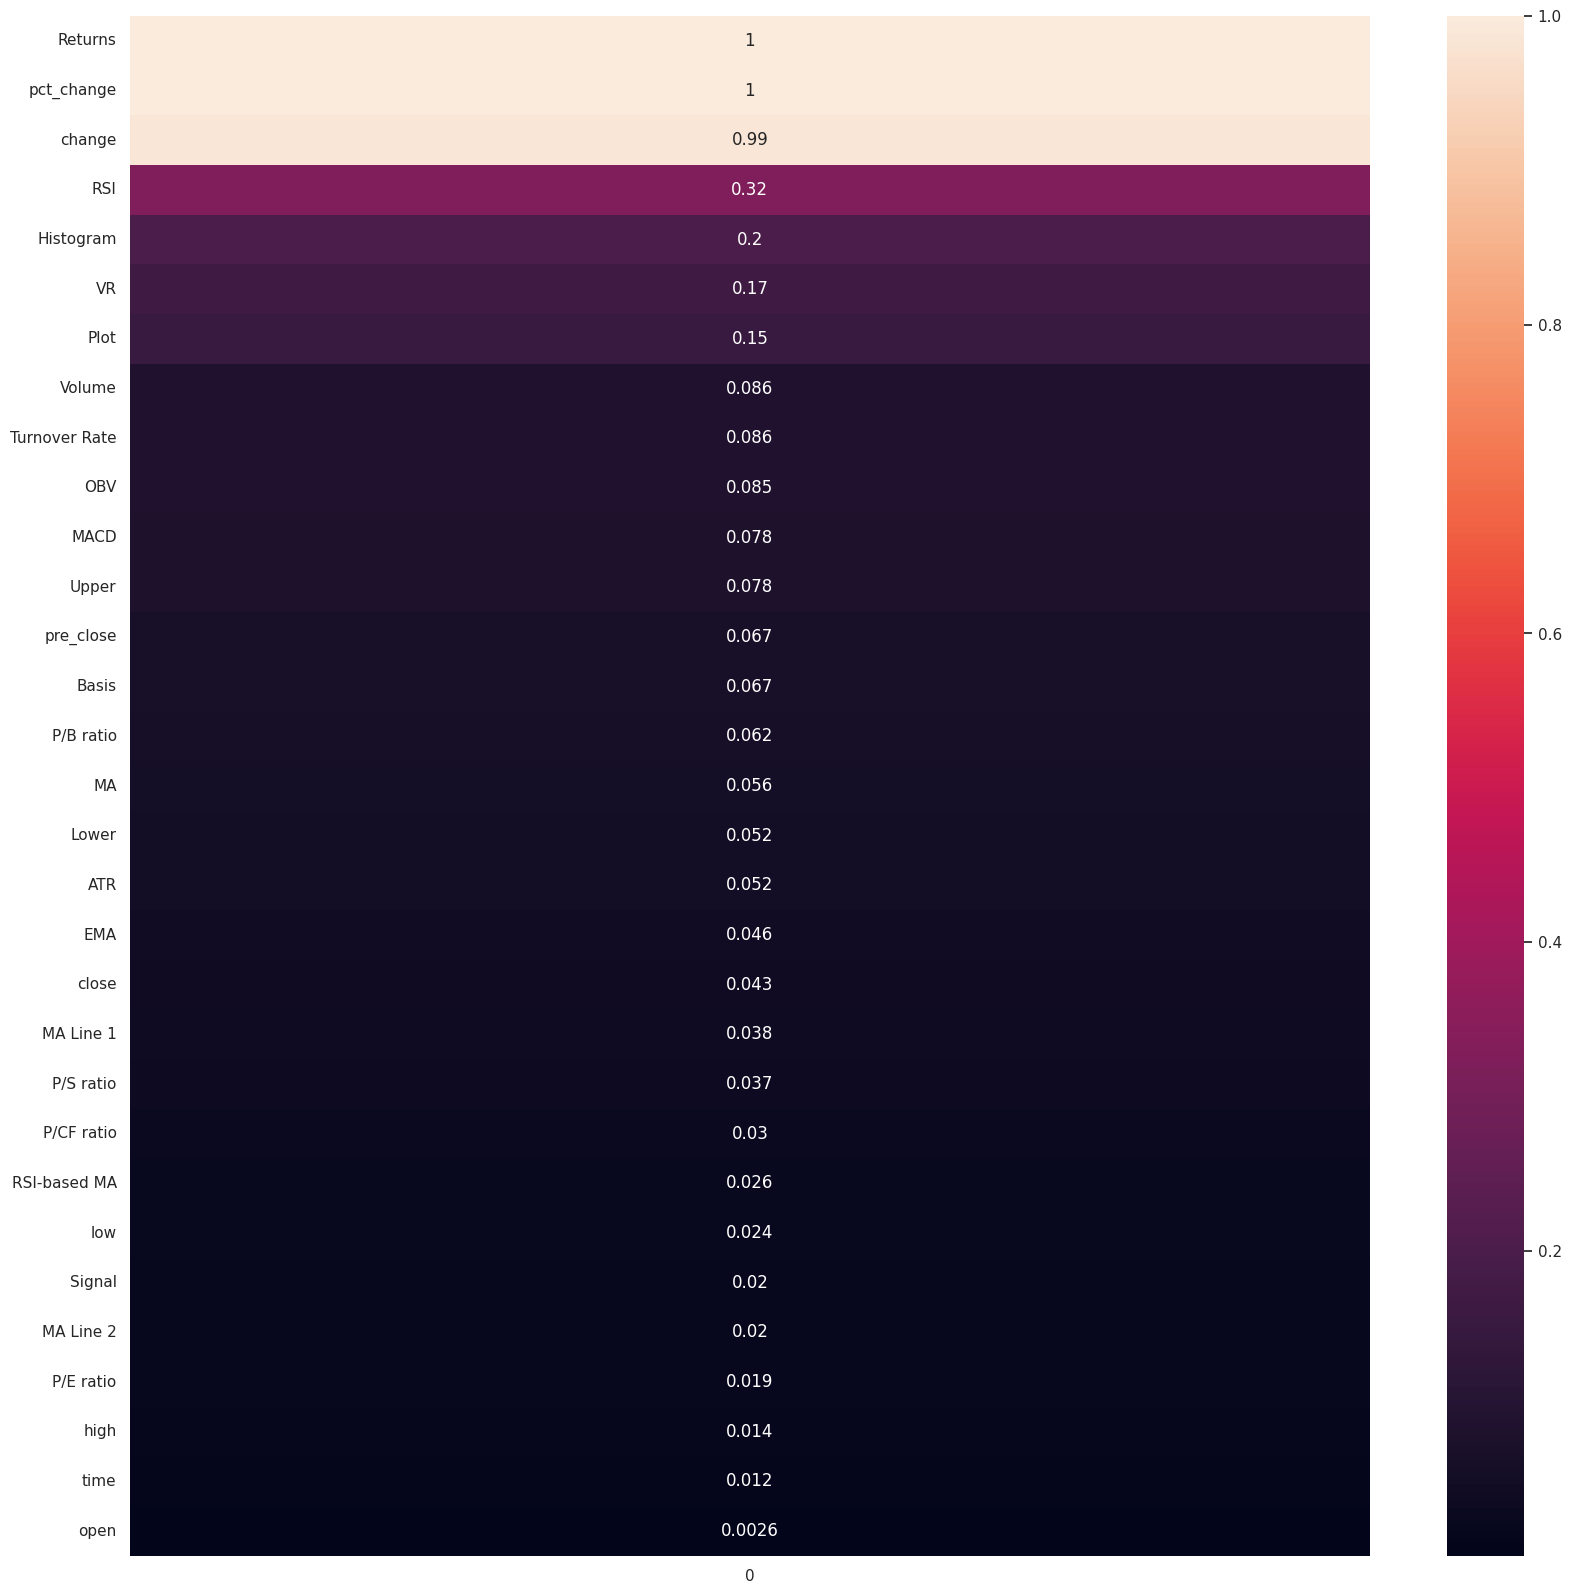

In [ ]:
Figure = plt.figure(figsize = (20,20))
Correlation = np.abs(Data.corr()["Returns"]).sort_values(ascending = False)
sns.heatmap(Correlation.values.reshape(-1,1), annot = True, yticklabels = Correlation.index)
plt.show()

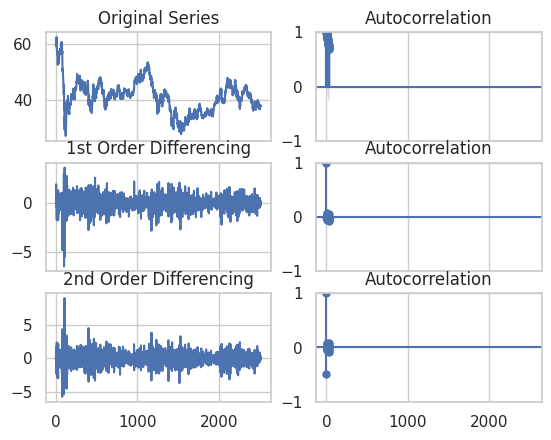

In [ ]:
#Determine the number of lags in the system
# Original Series
fig, axes = plt.subplots(3, 2, sharex=True)
axes[0, 0].plot(Data["close"].values); axes[0, 0].set_title('Original Series')
plot_acf(Data["close"].values, ax=axes[0, 1])
# 1st Differencing
axes[1, 0].plot(np.diff(Data["close"].values)); axes[1, 0].set_title('1st Order Differencing')
plot_acf(np.diff(Data["close"].values), ax=axes[1, 1])

# 2nd Differencing
axes[2, 0].plot(np.diff(np.diff(Data["close"].values))); axes[2, 0].set_title('2nd Order Differencing')
plot_acf(np.diff(np.diff(Data["close"].values)), ax=axes[2, 1])
plt.show()

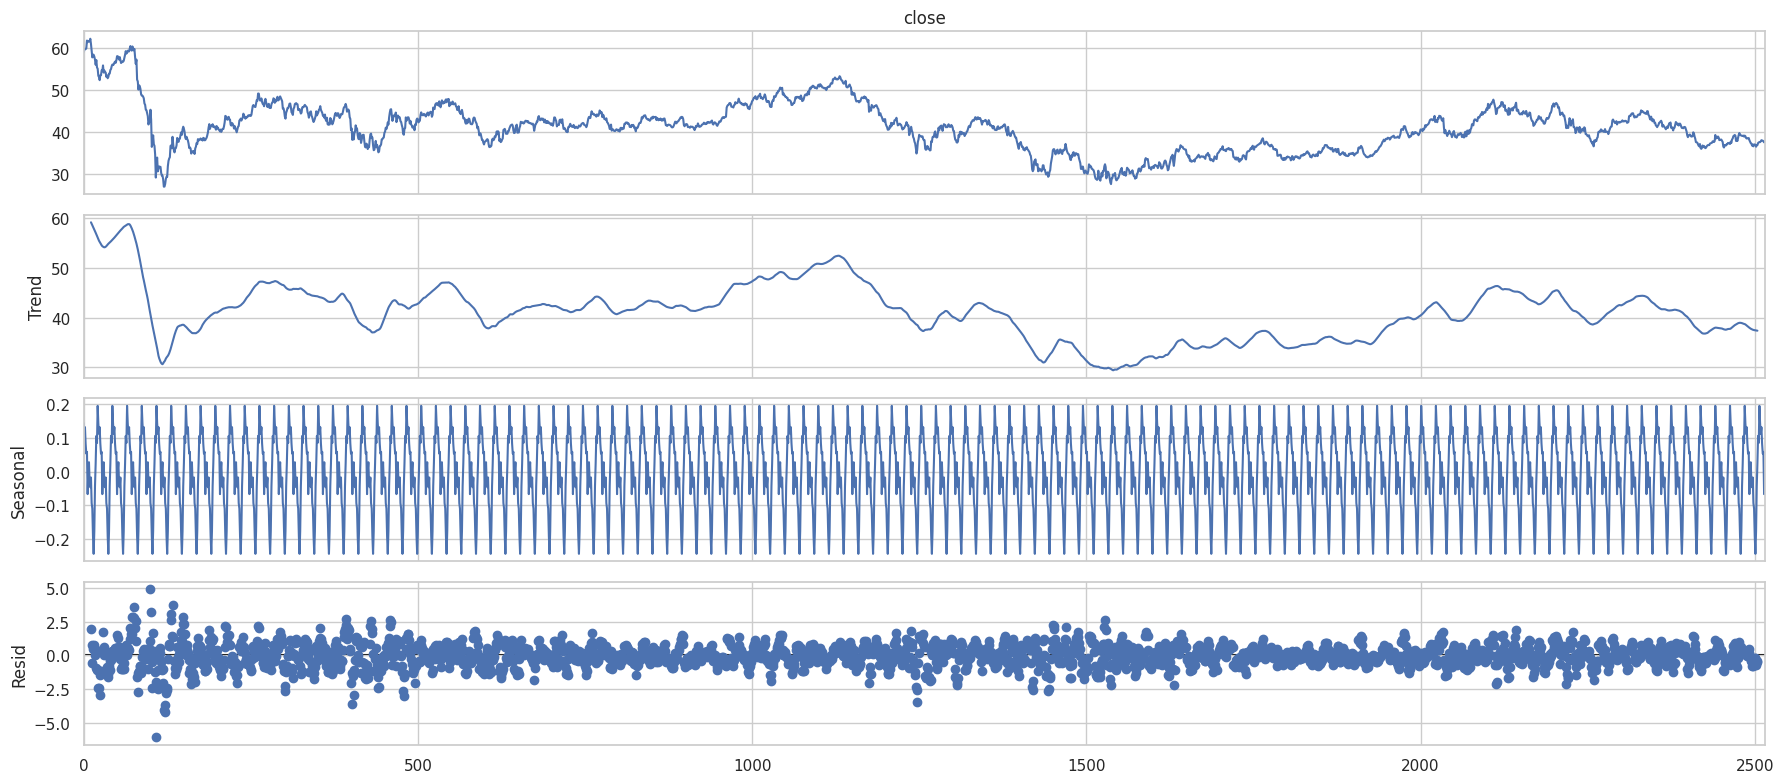

In [ ]:
# Plot the sesonal decomposition
import statsmodels.api as sm
from pylab import rcParams
rcParams['figure.figsize'] = 18, 8
decomposition = sm.tsa.seasonal_decompose(Data["close"].iloc[-10000:], model='additive', period = 22)
fig = decomposition.plot()
plt.tight_layout()
plt.show()

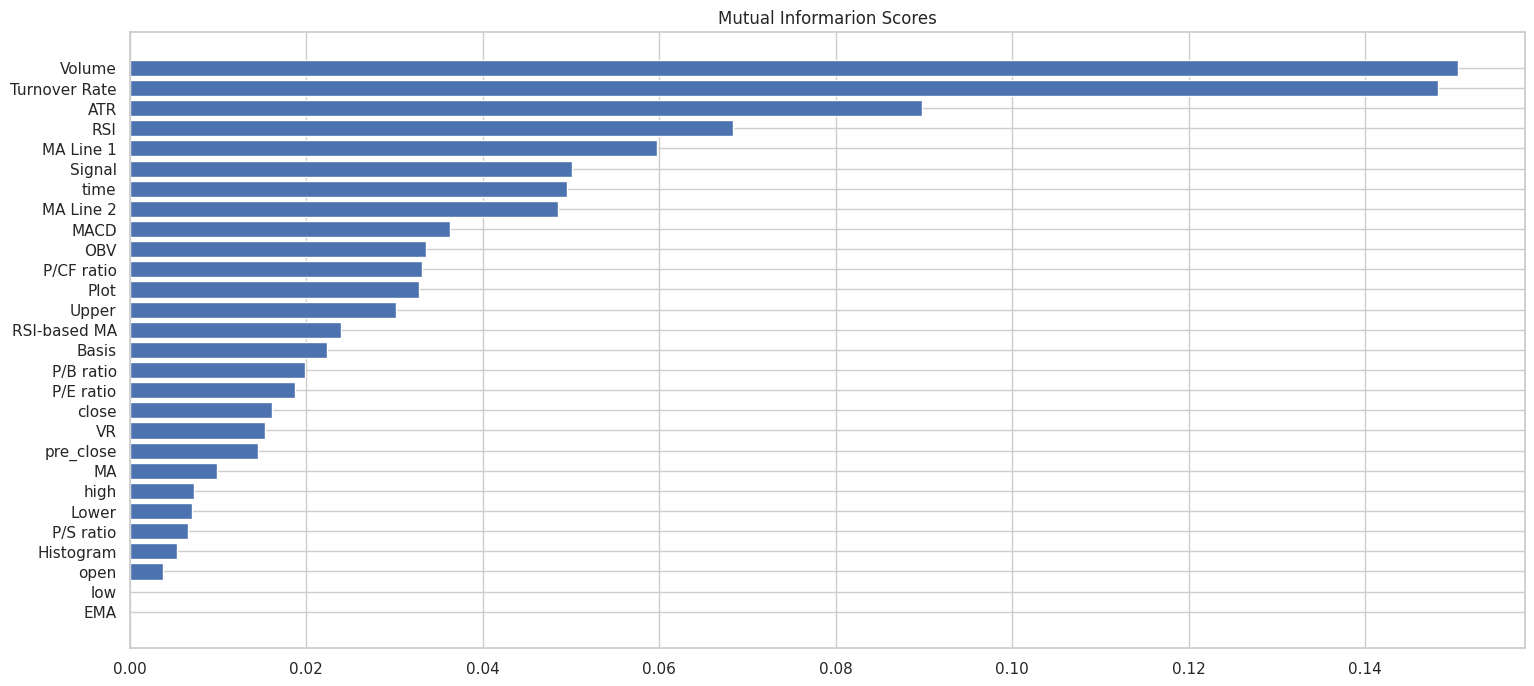

In [ ]:
Mi_Scores = make_mi_scores(Data.drop(columns = ["Returns", "pct_change", "change"]), Data["Returns"])
plot_mi_scores(Mi_Scores)

In [ ]:
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(Data["close"], autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)

1. ADF :  -4.232403801051538
2. P-Value :  0.0005804462197248652
3. Num Of Lags :  10
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 2505
5. Critical Values :
	 1% :  -3.4329631791044304
	 5% :  -2.8626944896608433
	 10% :  -2.5673845793841457


In [ ]:
def rolling_min_max_normalisation(series, window):
    return (series - series.rolling(window=window, min_periods=1).min()) / \
           (series.rolling(window=window, min_periods=1).max() - series.rolling(window=window, min_periods=1).min() + 1e-6)

def min_max_normalization(series, context=None):
    if context is not None:
        expanding_min = context[0]
        expanding_max = context[1] + 1e-6
    else:
        expanding_min = series.min()
        expanding_max = series.max() + 1e-6  # Adding small epsilon to avoid division by zero

    return (series - expanding_min) / (expanding_max - expanding_min), expanding_min, expanding_max

def rolling_z_score_scaler(series, window):
    rolling_mean = series.rolling(window=window, min_periods=1).mean()
    rolling_std = series.rolling(window=window, min_periods=1).std() + 1e-6
    return (series - rolling_mean) / rolling_std

def standard_z_score_norm(series, context = None):
    if context is not None:
        mean = context[0]
        std = context[1]
    else:
        mean = series.mean()
        std = series.std() + 1e-6

    return (series - mean)/(std), mean, std

In [ ]:
Data["close"].expanding(min_periods =1).min()[:1000]

,close
0,59.14999
1,59.14999
2,59.14999
3,59.14999
4,59.14999
...,...
995,27.02000
996,27.02000
997,27.02000
998,27.02000


In [ ]:
Data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2516 entries, 0 to 2515
Data columns (total 31 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   time           2516 non-null   float64
 1   open           2516 non-null   float64
 2   high           2516 non-null   float64
 3   low            2516 non-null   float64
 4   close          2516 non-null   float64
 5   pre_close      2516 non-null   float64
 6   change         2516 non-null   float64
 7   pct_change     2516 non-null   float64
 8   Volume         2516 non-null   float64
 9   Turnover Rate  2516 non-null   float64
 10  VR             2516 non-null   float64
 11  P/E ratio      2516 non-null   float64
 12  P/B ratio      2516 non-null   float64
 13  P/S ratio      2516 non-null   float64
 14  Basis          2516 non-null   float64
 15  Upper          2516 non-null   float64
 16  Lower          2516 non-null   float64
 17  EMA            2516 non-null   float64
 18  MA           

In [ ]:
def Feature_Engineering(file_name, sliding_window, validation_split, buffer):
    Data = pd.read_csv(file_name, parse_dates=['time']).dropna()

    # Extract the Dataset
    Data = Data[["time","open", "close", "high", "low", "Upper", "Lower", "Volume", "Turnover Rate", "ATR", "MA Line 1", "Signal", "MA Line 2", "MACD", "P/CF ratio", "EMA", "Basis", "Plot", "OBV"]]
    X,y = pd.DataFrame(), pd.DataFrame()

    Data["time"] = pd.to_datetime(Data["time"], format = "%d-%m-%Y")
    Data["weekday"] = Data["time"].dt.weekday
    Data["year"] = Data["time"].dt.year
    Data["month"] = Data["time"].dt.month
    Data["day"] = Data["time"].dt.day

    # Generate the Targets:
    y["returns"] = np.log(Data["close"] + 1e-6).diff().fillna(method = "bfill")
    y["close"] = Data['close']
    y["high"] = Data["high"]
    y["low"] = Data["low"]
    y["close"] = y["close"].fillna(method = "bfill")
    y["low"] = y["low"].fillna(method = "bfill")
    y["high"] = y["high"].fillna(method = "bfill")

    # Generate the Dates:
    X["weekday"] = Data["weekday"].fillna(method = "bfill")
    X["year"] = Data["year"].fillna(method = "bfill")
    X["month"] = Data["month"].fillna(method = "bfill")
    X["day"] = Data["day"].fillna(method = "bfill")

    # Generate the Original Features
    X["returns"] = y["returns"].fillna(method = "bfill")
    X["close"] = Data["close"].fillna(method = "bfill")
    X["open"] = Data["open"].fillna(method = "bfill")
    X["high"] = Data["high"].fillna(method = "bfill")
    X["low"] = Data["low"].fillna(method = "bfill")

    # Apply Some Feature Engineering:
    X[f"returns_{sliding_window}"] = y["returns"].rolling(sliding_window).mean().fillna(method = "bfill")
    X[f"returns_{sliding_window//2}"] = y["returns"].rolling(sliding_window//2).mean().fillna(method = "bfill")
    X[f"close_{sliding_window}"] = X["close"].rolling(24).mean().fillna(method = "bfill")
    X[f"close_{sliding_window}"] = X["close"].rolling(60).mean().fillna(method = "bfill")

    # Relative Returns Normalization
    X['open_rel'] = np.log(Data['open'] / Data['close'].shift(1))
    X['high_rel'] = np.log(Data['high'] / Data['close'].shift(1))
    X['low_rel'] = np.log(Data['low'] / Data['close'].shift(1))

    X[f"returns_{sliding_window-sliding_window//2}"] = X[f"returns_{sliding_window}"] -  X[f"returns_{sliding_window//2}"]
    X["Upper_Shadow"] = X["high"] - np.maximum(X["close"], X["open"])
    X["Lower_Shadow"] = X["low"] - np.minimum(X["close"], X["open"])

    X[f"Support_Level{sliding_window}"] = X["close"].rolling(sliding_window).min()
    X[f"Resistance_Level{sliding_window}"] = X["close"].rolling(sliding_window).max()

    X["upper_band"], X["middle_band"], X["lower_band"] = ta.BBANDS(X["close"])

    Decomposition = sm.tsa.seasonal_decompose(X["close"], model = "additive", period = sliding_window, two_sided = False)
    X["Trend"] = Decomposition.trend
    X["Seasonal"] = Decomposition.seasonal
    X["Residual"] = Decomposition.resid

    X["Volume"] = np.log(Data["Volume"] + 1e-6)
    X["Turnover Rate"] = np.log(Data["Turnover Rate"] + 1e-6)
    X["ATR"] = np.log(Data["ATR"] + 1e-6)
    X["MA Line 1"] = np.log(Data["MA Line 1"] + 1e-6)
    X["MA Line 2"] = np.log(Data["MA Line 2"] + 1e-6)
    X["Signal"] = Data["Signal"]
    X["MACD"] = Data["MACD"]
    X["P/CF ratio"] = Data["P/CF ratio"]
    X["Plot"] = Data["Plot"]
    X["OBV"] = np.log(Data["OBV"])
    X["EMA"] = Data["EMA"]
    X["Basis"] = Data["Basis"]
    X["Upper"] = Data["Upper"]
    X["Lower"] = Data["Lower"]

    X_Train, y_Train, X_Val, y_Val = X.iloc[:int(validation_split*len(X))], y.iloc[:int(validation_split*len(y))], X.iloc[int(validation_split*len(X)):], y.iloc[int(validation_split*len(y)):]

    Datetime_Features = ["weekday", "year", "month", "day"]
    X_Train_Normalised = X_Train.copy()
    X_Val_Normalised = X_Val.copy()

    X_Train_Normalised.iloc[:,4:], x_min, x_max = min_max_normalization(X_Train.iloc[:,4:])
    X_Val_Normalised.iloc[:,4:], _, _ = min_max_normalization(X_Val.iloc[:,4:], [x_min, x_max])

    buffer = sliding_window
    return X_Train_Normalised[buffer:], y_Train[buffer:], X_Val_Normalised[buffer:], y_Val[buffer:]# y_mean, y_std

In [ ]:
X_Train, y_Train, X_Val, y_Val = Feature_Engineering('/content/stock_dataset.csv', 22, 0.8, 100)
X_Train.shape, y_Train.shape, X_Val.shape, y_Val.shape

((1990, 39), (1990, 4), (482, 39), (482, 4))

In [ ]:
X_Train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1990 entries, 22 to 2011
Data columns (total 39 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   weekday             1990 non-null   int32  
 1   year                1990 non-null   int32  
 2   month               1990 non-null   int32  
 3   day                 1990 non-null   int32  
 4   returns             1990 non-null   float64
 5   close               1990 non-null   float64
 6   open                1990 non-null   float64
 7   high                1990 non-null   float64
 8   low                 1990 non-null   float64
 9   returns_22          1990 non-null   float64
 10  returns_11          1990 non-null   float64
 11  close_22            1990 non-null   float64
 12  open_rel            1990 non-null   float64
 13  high_rel            1990 non-null   float64
 14  low_rel             1990 non-null   float64
 15  Upper_Shadow        1990 non-null   float64
 16  Lower_Shad

In [ ]:
y_Train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1990 entries, 22 to 2011
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   returns  1990 non-null   float64
 1   close    1990 non-null   float64
 2   high     1990 non-null   float64
 3   low      1990 non-null   float64
dtypes: float64(4)
memory usage: 77.7 KB


In [ ]:
Train_X, Train_y = X_Train, y_Train
Train_X.shape, Train_y.shape

((1990, 39), (1990, 4))

In [ ]:
Valid_X, Valid_y = X_Val, y_Val
Valid_X.shape, Valid_y.shape

((482, 39), (482, 4))

In [ ]:
X = pd.concat([Train_X, Valid_X], axis = 0)
y = pd.concat([Train_y, Valid_y], axis = 0)
X.shape, y.shape

((2472, 39), (2472, 4))

<Figure size 5000x5000 with 0 Axes>

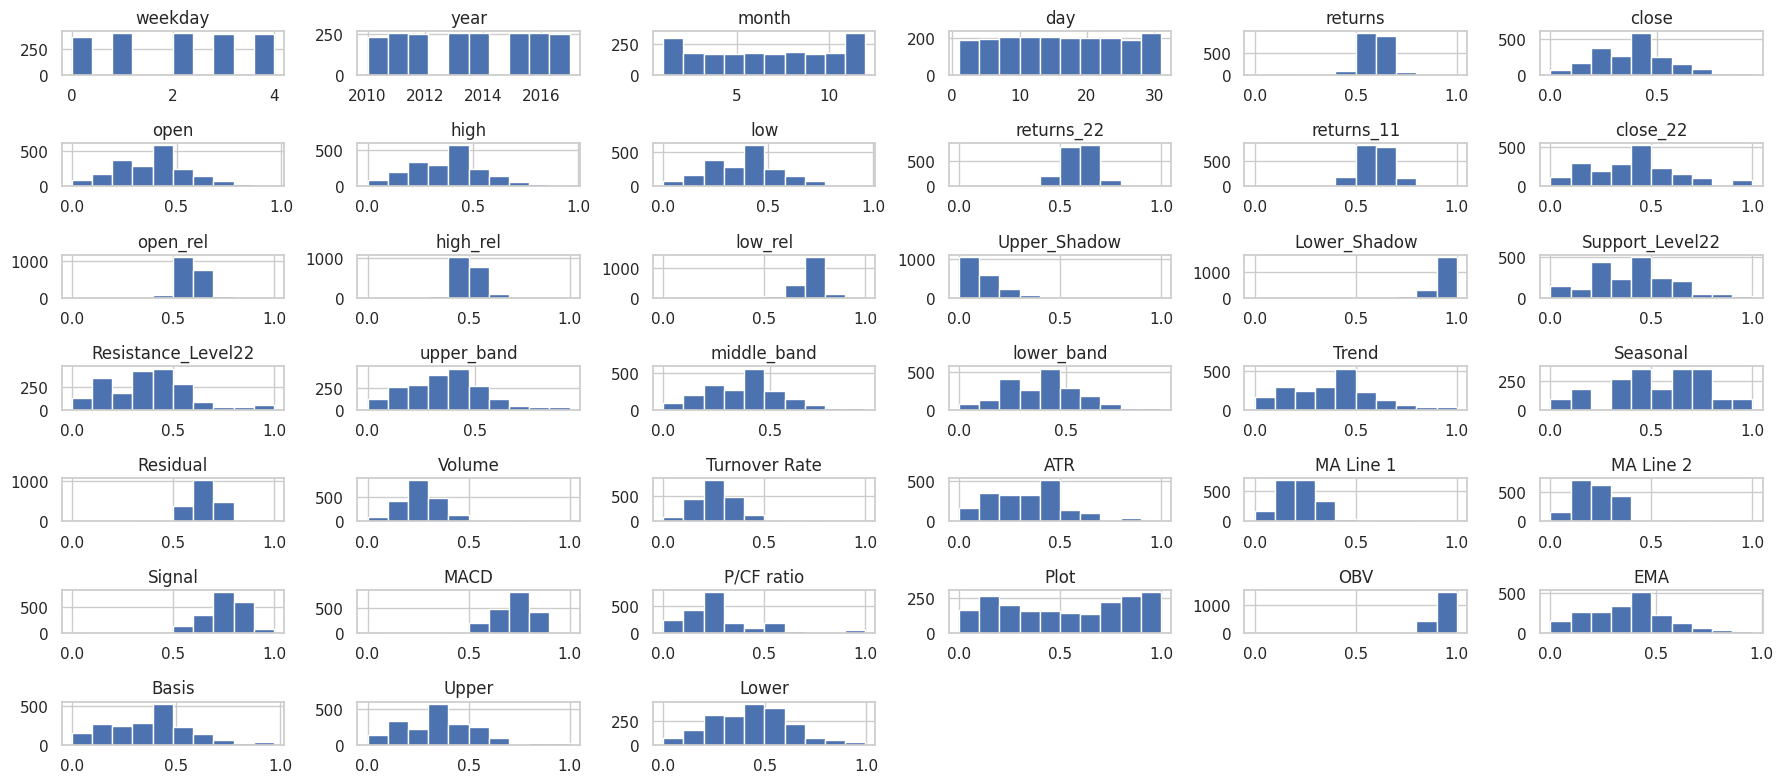

In [ ]:
Figure = plt.figure(figsize = (50,50))
X_Train.hist()
plt.tight_layout()
plt.show()

<Figure size 1000x1000 with 0 Axes>

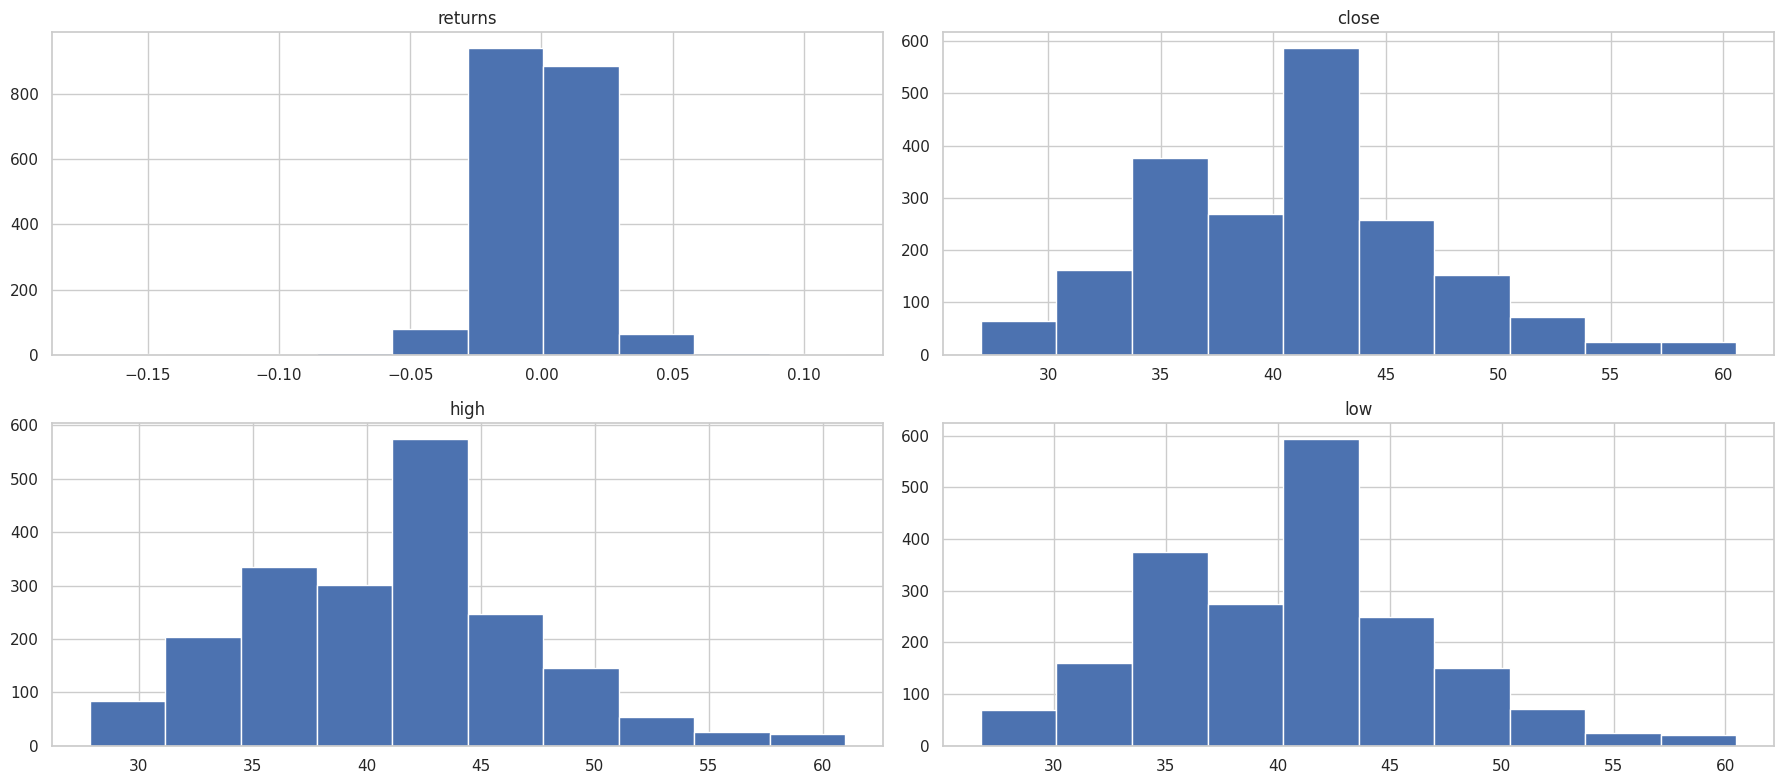

In [ ]:
Figure = plt.figure(figsize = (10,10))
y_Train.hist()
plt.tight_layout()
plt.show()

In [ ]:
def create_rolling_windows(data_X, data_y, window_size, prediction_horizon, n_steps):

    X,y = [], []
    data_values = data_X.values
    target_values = data_y.values
    print(data_X.shape, data_y.shape)
    print(len(data_X) - window_size - prediction_horizon - n_steps +1)
    for index in range(len(data_X) - window_size - prediction_horizon - n_steps +1):
        #print(index)
        window = data_values[index:index+window_size, :]
        X.append(window)

        target = target_values[index + window_size + prediction_horizon -1: index + window_size + prediction_horizon - 1 + n_steps, :]
        #print(target.shape)
        y.append(target)

    X = np.array(X)
    y = np.array(y)

    return X,y

In [ ]:
X_train_3d, y_train_3d = create_rolling_windows(X_Train, y_Train, 22, 1, 1)
X_train_3d.shape, y_train_3d.shape

(1990, 39) (1990, 4)
1967


((1967, 22, 39), (1967, 1, 4))

In [ ]:
X_valid_3d, y_valid_3d = create_rolling_windows(X_Val, y_Val, 22, 1, 1)
X_valid_3d.shape, y_valid_3d.shape

(482, 39) (482, 4)
459


((459, 22, 39), (459, 1, 4))

In [ ]:
X_3d, y_3d = create_rolling_windows(X, y, 22, 1, 1)
X_3d.shape, y_3d.shape

(2472, 39) (2472, 4)
2449


((2449, 22, 39), (2449, 1, 4))

In [ ]:
X_train_tensor = torch.tensor(X_train_3d, dtype = torch.float32)
y_train_tensor = torch.tensor(y_train_3d, dtype = torch.float32)
y_train_tensor = y_train_tensor.squeeze(1)
X_valid_tensor = torch.tensor(X_valid_3d, dtype = torch.float32)
y_valid_tensor = torch.tensor(y_valid_3d, dtype = torch.float32)
y_valid_tensor = y_valid_tensor.squeeze(1)

X_test_tensor = torch.tensor(X_3d, dtype = torch.float32)
y_test_tensor = torch.tensor(y_3d, dtype = torch.float32)
y_test_tensor = y_test_tensor.squeeze(1)

In [ ]:
class TimeSeriesDataset(torch.utils.data.Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        #print(self.X.shape)
        return self.X[idx, :, 4:], self.y[idx], idx

    def __getdate__(self, idx):
        return self.X[idx, :, :4]

Train_Dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
Valid_Dataset = TimeSeriesDataset(X_valid_tensor, y_valid_tensor)

Train_Loader = torch.utils.data.DataLoader(Train_Dataset, batch_size = 32, shuffle = True)
Validation_Loader = torch.utils.data.DataLoader(Valid_Dataset, batch_size = 32, shuffle = False)

len(Train_Loader), len(Validation_Loader)

(62, 15)

In [ ]:
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

def calculate_metrics(y_true, y_pred):
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)
    mape = mean_absolute_percentage_error(y_true, y_pred)
    return mse, rmse, mae, r2, mape

In [ ]:
import math
from dataclasses import dataclass
from typing import Union

import torch
import torch.nn as nn
import torch.nn.functional as F

# from pscan import Scan


class MambaConfig:
    d_model: int = 35 # D
    n_layers: int = 10
    dt_rank: int = math.ceil(d_model / 16)
    d_state: int = 6 # N in paper/comments
    expand_factor: int = 2 # E in paper/comments
    d_conv: int = 4
    output_size: int = 4

    dt_min: float = 0.001
    dt_max: float = 0.1
    dt_init: str = "random" # "random" or "constant"
    dt_scale: float = 1.0
    dt_init_floor = 1e-4

    bias: bool = False
    conv_bias: bool = True

    pscan: bool = True # use parallel scan mode or sequential mode when training

    # def __post_init__(self):
    d_inner = expand_factor * d_model # E*D = ED in comments

    # if self.dt_rank == 'auto':
    #     self.dt_rank = math.ceil(self.d_model / 16)

    learning_rate: float = 5e-4
    weight_decay: float = 1e-4

class PScan(torch.autograd.Function):
    @staticmethod
    def pscan(A, X):
        # A : (B, D, L, N)
        # X : (B, D, L, N)

        # modifies X in place by doing a parallel scan.
        # more formally, X will be populated by these values :
        # H[t] = A[t] * H[t-1] + X[t] with H[0] = 0
        # which are computed in parallel (2*log2(T) sequential steps (ideally), instead of T sequential steps)

        B, D, L, _ = A.size()
        num_steps = int(math.log2(L))

        # up sweep or reduction step
        Aa = A
        Xa = X
        for k in range(num_steps):
            T = 2 * (Xa.size(2) // 2)

            Aa = Aa[:, :, :T].view(B, D, T // 2, 2, -1)
            Xa = Xa[:, :, :T].view(B, D, T // 2, 2, -1)

            Xa[:, :, :, 1].add_(Aa[:, :, :, 1].mul(Xa[:, :, :, 0]))
            Aa[:, :, :, 1].mul_(Aa[:, :, :, 0])

            Aa = Aa[:, :, :, 1]
            Xa = Xa[:, :, :, 1]

        # down sweep
        for k in range(num_steps - 1, -1, -1):
            Aa = A[:, :, 2**k - 1 : L : 2**k]
            Xa = X[:, :, 2**k - 1 : L : 2**k]

            T = 2 * (Xa.size(2) // 2)

            if T < Xa.size(2):
                Xa[:, :, -1].add_(Aa[:, :, -1].mul(Xa[:, :, -2]))
                Aa[:, :, -1].mul_(Aa[:, :, -2])

            Aa = Aa[:, :, :T].view(B, D, T // 2, 2, -1)
            Xa = Xa[:, :, :T].view(B, D, T // 2, 2, -1)

            Xa[:, :, 1:, 0].add_(
                Aa[:, :, 1:, 0].mul(Xa[:, :, :-1, 1])
            )
            Aa[:, :, 1:, 0].mul_(Aa[:, :, :-1, 1])

    @staticmethod
    def forward(ctx, A_in, X_in):
        """
        Applies the parallel scan operation, as defined above. Returns a new tensor.

        Args:
            A_in : (B, L, D, N)
            X_in : (B, L, D, N)

        Returns:
            H : (B, L, D, N)
        """

        # clone tensor (in-place ops)
        A = A_in.clone()  # (B, L, D, N)
        X = X_in.clone()  # (B, L, D, N)

        # prepare tensors
        A = A.transpose(2, 1)  # (B, D, L, N)
        X = X.transpose(2, 1)  # (B, D, L, N)

        # parallel scan
        PScan.pscan(A, X)

        ctx.save_for_backward(A_in, X)

        return X.transpose(2, 1)

    @staticmethod
    def backward(ctx, grad_output_in):
        """
        Flows the gradient from the output to the input. Returns two new tensors.

        Args:
            ctx : A_in : (B, L, D, N), X : (B, D, L, N)
            grad_output_in : (B, L, D, N)

        Returns:
            gradA : (B, L, D, N), gradX : (B, L, D, N)
        """

        A_in, X = ctx.saved_tensors

        # clone tensors
        A = A_in.clone()
        # grad_output_in will be cloned with flip()

        # prepare tensors
        A = A.transpose(2, 1)  # (B, D, L, N)
        A = torch.cat((A[:, :, :1], A[:, :, 1:].flip(2)), dim=2)
        grad_output_b = grad_output_in.transpose(2, 1)

        # reverse parallel scan
        grad_output_b = grad_output_b.flip(2)
        PScan.pscan(A, grad_output_b)
        grad_output_b = grad_output_b.flip(2)

        Q = torch.zeros_like(X)
        Q[:, :, 1:].add_(X[:, :, :-1] * grad_output_b[:, :, 1:])

        return Q.transpose(2, 1), grad_output_b.transpose(2, 1)


pscan = PScan.apply

class Mamba(pL.LightningModule):
    def __init__(self, config: MambaConfig):
        super().__init__()

        self.config = config

        self.layers = nn.ModuleList([ResidualBlock(config) for _ in range(config.n_layers)])
        self.norm_f = RMSNorm(config.d_model)
        self.fc = nn.Linear(config.d_model, config.output_size)
        self.learning_rate = config.learning_rate
        self.weight_decay = config.weight_decay

    def forward(self, x):
        # x : (B, L, D)

        # y : (B, L, D)

        for layer in self.layers:
            x = layer(x)

        x = self.norm_f(x)
        x = self.fc(x[:, -1, :])

        return x

    def step(self, x, caches):
        # x : (B, L, D)
        # caches : [cache(layer) for all layers], cache : (h, inputs)

        # y : (B, L, D)
        # caches : [cache(layer) for all layers], cache : (h, inputs)

        for i, layer in enumerate(self.layers):
            x, caches[i] = layer.step(x, caches[i])

        return x, caches

    def predict(self, x):
        return self.forward(x)

    def training_step(self, batch, batch_idx = None):
        X,y, _ = batch
        predicted = self.forward(X)
        train_loss = F.mse_loss(predicted, y)
        learning_rate = self.trainer.optimizers[0].param_groups[0]['lr']
        self.log("learning_rate", self.learning_rate, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        self.log("train_loss", train_loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return train_loss

    def validation_step(self, batch, batch_idx = None):
        X,y, _ = batch
        predicted = self.forward(X)
        valid_loss = F.mse_loss(predicted, y)
        self.log("valid_loss", valid_loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return valid_loss

    def test_step(self, batch, batch_idx = None):
        X,y, _ = batch
        predicted = self.forward(X)
        test_loss = F.mse_loss(predicted, y)
        self.log("test_loss", test_loss, on_step = False, on_epoch = True, prog_bar = True, logger = True)
        return test_loss

    def configure_optimizers(self):
        optimizer = optim.AdamW(self.parameters(), lr = self.learning_rate, weight_decay = self.weight_decay)
        Scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.6, patience=5, verbose=True, min_lr=1e-8)

        Scheduler = {
            'scheduler': Scheduler,
            'monitor': 'valid_loss',
            'interval': 'epoch',
            'frequency': 1,
            'strict': True
        }
        return [optimizer], [Scheduler]

class ResidualBlock(nn.Module):
    def __init__(self, config: MambaConfig):
        super().__init__()

        self.mixer = MambaBlock(config)
        self.norm = RMSNorm(config.d_model)

    def forward(self, x):
        # x : (B, L, D)

        # output : (B, L, D)

        output = self.mixer(self.norm(x)) + x
        return output

    def step(self, x, cache):
        # x : (B, D)
        # cache : (h, inputs)
                # h : (B, ED, N)
                # inputs: (B, ED, d_conv-1)

        # output : (B, D)
        # cache : (h, inputs)

        output, cache = self.mixer.step(self.norm(x), cache)
        output = output + x
        return output, cache

class MambaBlock(nn.Module):
    def __init__(self, config: MambaConfig):
        super().__init__()

        self.config = config

        # projects block input from D to 2*ED (two branches)
        self.in_proj = nn.Linear(config.d_model, 2 * config.d_inner, bias=config.bias)

        self.conv1d = nn.Conv1d(in_channels=config.d_inner, out_channels=config.d_inner,
                              kernel_size=config.d_conv, bias=config.conv_bias,
                              groups=config.d_inner,
                              padding=config.d_conv - 1)

        # projects x to input-dependent Δ, B, C
        self.x_proj = nn.Linear(config.d_inner, config.dt_rank + 2 * config.d_state, bias=False)

        # projects Δ from dt_rank to d_inner
        self.dt_proj = nn.Linear(config.dt_rank, config.d_inner, bias=True)

        # dt initialization
        # dt weights
        dt_init_std = config.dt_rank**-0.5 * config.dt_scale
        if config.dt_init == "constant":
            nn.init.constant_(self.dt_proj.weight, dt_init_std)
        elif config.dt_init == "random":
            nn.init.uniform_(self.dt_proj.weight, -dt_init_std, dt_init_std)
        else:
            raise NotImplementedError

        # dt bias
        dt = torch.exp(
            torch.rand(config.d_inner) * (math.log(config.dt_max) - math.log(config.dt_min)) + math.log(config.dt_min)
        ).clamp(min=config.dt_init_floor)
        inv_dt = dt + torch.log(-torch.expm1(-dt)) # inverse of softplus: https://github.com/pytorch/pytorch/issues/72759
        with torch.no_grad():
            self.dt_proj.bias.copy_(inv_dt)
        #self.dt_proj.bias._no_reinit = True # initialization would set all Linear.bias to zero, need to mark this one as _no_reinit
        # todo : explain why removed

        # S4D real initialization
        A = torch.arange(1, config.d_state + 1, dtype=torch.float32).repeat(config.d_inner, 1)
        self.A_log = nn.Parameter(torch.log(A)) # why store A in log ? to keep A < 0 (cf -torch.exp(...)) ? for gradient stability ?
        self.D = nn.Parameter(torch.ones(config.d_inner))

        # projects block output from ED back to D
        self.out_proj = nn.Linear(config.d_inner, config.d_model, bias=config.bias)

    def forward(self, x):
        # x : (B, L, D)

        # y : (B, L, D)

        _, L, _ = x.shape

        xz = self.in_proj(x) # (B, L, 2*ED)
        x, z = xz.chunk(2, dim=-1) # (B, L, ED), (B, L, ED)

        # x branch
        x = x.transpose(1, 2) # (B, ED, L)
        x = self.conv1d(x)[:, :, :L] # depthwise convolution over time, with a short filter
        x = x.transpose(1, 2) # (B, L, ED)

        x = F.silu(x)
        y = self.ssm(x)

        # z branch
        z = F.silu(z)

        output = y * z
        output = self.out_proj(output) # (B, L, D)

        return output

    def ssm(self, x):
        # x : (B, L, ED)

        # y : (B, L, ED)

        A = -torch.exp(self.A_log.float()) # (ED, N)
        D = self.D.float()
        # TODO remove .float()

        deltaBC = self.x_proj(x) # (B, L, dt_rank+2*N)

        delta, B, C = torch.split(deltaBC, [self.config.dt_rank, self.config.d_state, self.config.d_state], dim=-1) # (B, L, dt_rank), (B, L, N), (B, L, N)
        delta = F.softplus(self.dt_proj(delta)) # (B, L, ED)

        if self.config.pscan:
            y = self.selective_scan(x, delta, A, B, C, D)
        else:
            y = self.selective_scan_seq(x, delta, A, B, C, D)

        return y

    def selective_scan(self, x, delta, A, B, C, D):
        # x : (B, L, ED)
        # Δ : (B, L, ED)
        # A : (ED, N)
        # B : (B, L, N)
        # C : (B, L, N)
        # D : (ED)

        # y : (B, L, ED)

        deltaA = torch.exp(delta.unsqueeze(-1) * A) # (B, L, ED, N)
        deltaB = delta.unsqueeze(-1) * B.unsqueeze(2) # (B, L, ED, N)

        BX = deltaB * (x.unsqueeze(-1)) # (B, L, ED, N)

        hs = pscan(deltaA, BX)

        y = (hs @ C.unsqueeze(-1)).squeeze(3) # (B, L, ED, N) @ (B, L, N, 1) -> (B, L, ED, 1)

        y = y + D * x

        return y

    def selective_scan_seq(self, x, delta, A, B, C, D):
        # x : (B, L, ED)
        # Δ : (B, L, ED)
        # A : (ED, N)
        # B : (B, L, N)
        # C : (B, L, N)
        # D : (ED)

        # y : (B, L, ED)

        _, L, _ = x.shape

        deltaA = torch.exp(delta.unsqueeze(-1) * A) # (B, L, ED, N)
        deltaB = delta.unsqueeze(-1) * B.unsqueeze(2) # (B, L, ED, N)

        BX = deltaB * (x.unsqueeze(-1)) # (B, L, ED, N)

        h = torch.zeros(x.size(0), self.config.d_inner, self.config.d_state, device=deltaA.device) # (B, ED, N)
        hs = []

        for t in range(0, L):
            h = deltaA[:, t] * h + BX[:, t]
            hs.append(h)

        hs = torch.stack(hs, dim=1) # (B, L, ED, N)

        y = (hs @ C.unsqueeze(-1)).squeeze(3) # (B, L, ED, N) @ (B, L, N, 1) -> (B, L, ED, 1)

        y = y + D * x

        return y

    # -------------------------- inference -------------------------- #
    """
    Concerning auto-regressive inference

    The cool part of using Mamba : inference is constant wrt to sequence length
    We just have to keep in cache, for each layer, two things :
    - the hidden state h (which is (B, ED, N)), as you typically would when doing inference with a RNN
    - the last d_conv-1 inputs of the layer, to be able to compute the 1D conv which is a convolution over the time dimension
      (d_conv is fixed so this doesn't incur a growing cache as we progress on generating the sequence)
      (and d_conv is usually very small, like 4, so we just have to "remember" the last 3 inputs)

    Concretely, these two quantities are put inside a cache tuple, and are named h and inputs respectively.
    h is (B, ED, N), and inputs is (B, ED, d_conv-1)
    The MambaBlock.step() receives this cache, and, along with outputing the output, alos outputs the updated cache for the next call.

    The cache object is initialized as follows : (None, torch.zeros()).
    When h is None, the selective scan function detects it and start with h=0.
    The torch.zeros() isn't a problem (it's same as just feeding the input, because the conv1d is padded)

    As we need one such cache variable per layer, we store a caches object, which is simply a list of cache object. (See mamba_lm.py)
    """

    def step(self, x, cache):
        # x : (B, D)
        # cache : (h, inputs)
                # h : (B, ED, N)
                # inputs : (B, ED, d_conv-1)

        # y : (B, D)
        # cache : (h, inputs)

        h, inputs = cache

        xz = self.in_proj(x) # (B, 2*ED)
        x, z = xz.chunk(2, dim=1) # (B, ED), (B, ED)

        # x branch
        x_cache = x.unsqueeze(2)
        x = self.conv1d(torch.cat([inputs, x_cache], dim=2))[:, :, self.config.d_conv-1] # (B, ED)

        x = F.silu(x)
        y, h = self.ssm_step(x, h)

        # z branch
        z = F.silu(z)

        output = y * z
        output = self.out_proj(output) # (B, D)

        # prepare cache for next call
        inputs = torch.cat([inputs[:, :, 1:], x_cache], dim=2) # (B, ED, d_conv-1)
        cache = (h, inputs)

        return output, cache

    def ssm_step(self, x, h):
        # x : (B, ED)
        # h : (B, ED, N)

        # y : (B, ED)
        # h : (B, ED, N)

        A = -torch.exp(self.A_log.float()) # (ED, N) # todo : ne pas le faire tout le temps, puisque c'est indépendant de la timestep
        D = self.D.float()
        # TODO remove .float()

        deltaBC = self.x_proj(x) # (B, dt_rank+2*N)

        delta, B, C = torch.split(deltaBC, [self.config.dt_rank, self.config.d_state, self.config.d_state], dim=-1) # (B, dt_rank), (B, N), (B, N)
        delta = F.softplus(self.dt_proj(delta)) # (B, ED)

        deltaA = torch.exp(delta.unsqueeze(-1) * A) # (B, ED, N)
        deltaB = delta.unsqueeze(-1) * B.unsqueeze(1) # (B, ED, N)

        BX = deltaB * (x.unsqueeze(-1)) # (B, ED, N)

        if h is None:
            h = torch.zeros(x.size(0), self.config.d_inner, self.config.d_state, device=deltaA.device) # (B, ED, N)

        h = deltaA * h + BX # (B, ED, N)

        y = (h @ C.unsqueeze(-1)).squeeze(2) # (B, ED, N) @ (B, N, 1) -> (B, ED, 1)

        y = y + D * x

        # todo : pq h.squeeze(1) ??
        return y, h.squeeze(1)

# taken straight from https://github.com/johnma2006/mamba-minimal/blob/master/model.py
class RMSNorm(nn.Module):
    def __init__(self, d_model: int, eps: float = 1e-5):
        super().__init__()

        self.eps = eps
        self.weight = nn.Parameter(torch.ones(d_model))

    def forward(self, x):
        output = x * torch.rsqrt(x.pow(2).mean(-1, keepdim=True) + self.eps) * self.weight

        return output

In [ ]:
model = Mamba(MambaConfig)

In [ ]:
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping, LearningRateMonitor
checkpoint_callback = ModelCheckpoint(monitor = "valid_loss", save_top_k = 1, mode = "min", filename = "BestCheckpoint", save_weights_only = True)
Trainer = pL.Trainer(gradient_clip_val=1.0,
                     accelerator= "gpu", devices = [0],
                     max_epochs=100,
                     callbacks=[LearningRateMonitor("epoch"),
                                EarlyStopping('valid_loss', patience=15, mode = "min"),
                                checkpoint_callback],
                    )
Trainer.fit(model, Train_Loader, Validation_Loader)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.utilities.rank_zero:You are using a CUDA device ('NVIDIA A100-SXM4-40GB') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
INFO:pytorch_lightning.callbacks.model_summary:
  | Name   | Type       | Params | Mode 
----------------------------------------------
0 | layers | ModuleList | 95.5 K | train
1 | norm_f | RMSNorm    | 35     | train
2 | fc     | Linear     | 144    | train
--------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [ ]:
Trainer.test(model, Validation_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.26107147336006165    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.26107147336006165}]

In [ ]:

replace = False
if os.path.exists('/content/checkpoints/Mamba_BestCheckpoint.ckpt') and replace == True:
    best_model_path = '/content/checkpoints/Mamba_BestCheckpoint.ckpt'
else:
  print("New Checkpoint Generated")
  best_model_path = checkpoint_callback.best_model_path  # This gives the path of the best checkpoint saved
print(f"Best model saved at: {best_model_path}")

# Load the model weights into a new instance
# Assuming these are the arguments you used when initializing the model
best_model = Mamba.load_from_checkpoint(
    checkpoint_path=best_model_path,
    config = MambaConfig

).to("cuda")
if not replace:
  files.download(best_model_path)

New Checkpoint Generated
Best model saved at: /content/lightning_logs/version_0/checkpoints/BestCheckpoint.ckpt


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
Trainer.test(best_model, Train_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.31087660789489746    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.31087660789489746}]

In [ ]:
Trainer.test(best_model, Validation_Loader)

INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.20168562233448029    │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.20168562233448029}]

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import torch.nn.functional as F
from datetime import datetime, timedelta

best_model.eval()
n_steps = 1
device = "cuda"
best_model = best_model.to(device)

predicted_values = np.array([])
target_values = np.array([])
Datetime_Object = []

with torch.no_grad():
    for batch_idx, element in enumerate(Validation_Loader):
        X, y, indices = element  # Now retrieve the indices from the DataLoader
        X = X.to(device)
        y = y.to(device)

        # Predict using the model
        predicted = best_model(X).detach().cpu()
        mse_loss = F.mse_loss(predicted, y.cpu(), reduction="mean")

        # Print shapes for debugging
        #print(X.shape)
        #print(predicted.shape)
        #print(y.shape)

        # Fetch the datetime information using the correct indices
        date_batch = Valid_Dataset.__getdate__(indices).detach().cpu().numpy()
        Dates = []
        for date in range(len(date_batch)):
          Date_Time = datetime(int(date_batch[date, -1, 1]), int(date_batch[date, -1, 2]), int(date_batch[date, -1, 3]))
          Dates.append(Date_Time + timedelta(days=n_steps))

        if batch_idx == 0:
            predicted_values = predicted.numpy()
            target_values = y.cpu().numpy()
            Datetime_Object = Dates
        else:
            predicted_values = np.concatenate([predicted_values, predicted.numpy()], axis=0)
            target_values = np.concatenate([target_values, y.cpu().numpy()], axis=0)
            Datetime_Object = np.concatenate([Datetime_Object, Dates], axis=0)

# Continue with your evaluation metrics, e.g., mean_squared_error, etc.
predicted_values = np.array(predicted_values)
Datetime_Object = np.array(Datetime_Object)
predicted_values, target_values,

(array([[-6.4399093e-03,  3.9470669e+01,  3.9769852e+01,  3.9119659e+01],
        [-2.6398152e-03,  3.9626694e+01,  3.9944645e+01,  3.9275894e+01],
        [-3.0506998e-03,  3.9344601e+01,  3.9655945e+01,  3.8999954e+01],
        ...,
        [ 2.9019266e-03,  3.8184708e+01,  3.8341785e+01,  3.7974083e+01],
        [ 9.0532005e-04,  3.8230396e+01,  3.8426254e+01,  3.7982315e+01],
        [-1.6274452e-03,  3.8087086e+01,  3.8283562e+01,  3.7834808e+01]],
       dtype=float32),
 array([[ 9.9098766e-03,  3.9549999e+01,  3.9799999e+01,  3.9365002e+01],
        [-6.0867546e-03,  3.9310001e+01,  3.9599998e+01,  3.9049999e+01],
        [ 3.8085610e-03,  3.9459999e+01,  3.9525002e+01,  3.9230000e+01],
        ...,
        [-1.5785323e-03,  3.7980000e+01,  3.8200001e+01,  3.7939999e+01],
        [-3.1645596e-03,  3.7860001e+01,  3.8250000e+01,  3.7860001e+01],
        [-6.8910951e-03,  3.7599998e+01,  3.7967999e+01,  3.7570000e+01]],
       dtype=float32))

In [ ]:
Dataset = pd.concat([pd.DataFrame(Datetime_Object, columns = ["DateTime"]), pd.DataFrame(predicted_values, columns = ["returns", "close", "high", "low"]), pd.DataFrame(target_values, columns = ["target_returns", "target_close", "target_high", "target_low"])], axis = 1)
Dataset

,DateTime,returns,close,high,low,target_returns,target_close,target_high,target_low
0,2018-03-06,-0.006440,39.470669,39.769852,39.119659,0.009910,39.549999,39.799999,39.365002
1,2018-03-07,-0.002640,39.626694,39.944645,39.275894,-0.006087,39.310001,39.599998,39.049999
2,2018-03-08,-0.003051,39.344601,39.655945,38.999954,0.003809,39.459999,39.525002,39.230000
3,2018-03-09,0.001887,39.575111,39.816357,39.297359,0.005056,39.660000,39.814999,39.570000
4,2018-03-10,0.003801,39.850632,40.086533,39.586056,0.004779,39.849998,39.880001,39.580002
...,...,...,...,...,...,...,...,...,...
454,2019-12-21,-0.002174,38.143883,38.355179,37.881310,0.006846,38.110001,38.119999,37.709999
455,2019-12-24,-0.001693,38.307117,38.504486,38.052200,-0.001838,38.040001,38.139999,37.959999
456,2019-12-25,0.002902,38.184708,38.341785,37.974083,-0.001579,37.980000,38.200001,37.939999
457,2019-12-27,0.000905,38.230396,38.426254,37.982315,-0.003165,37.860001,38.250000,37.860001


In [ ]:
Save_Dataset = Dataset[["close", "returns"]]
Save_Dataset

,close,returns
0,39.470669,-0.006440
1,39.626694,-0.002640
2,39.344601,-0.003051
3,39.575111,0.001887
4,39.850632,0.003801
...,...,...
454,38.143883,-0.002174
455,38.307117,-0.001693
456,38.184708,0.002902
457,38.230396,0.000905


In [ ]:
Save_Dataset.to_csv("Mamba_Predictions.csv")

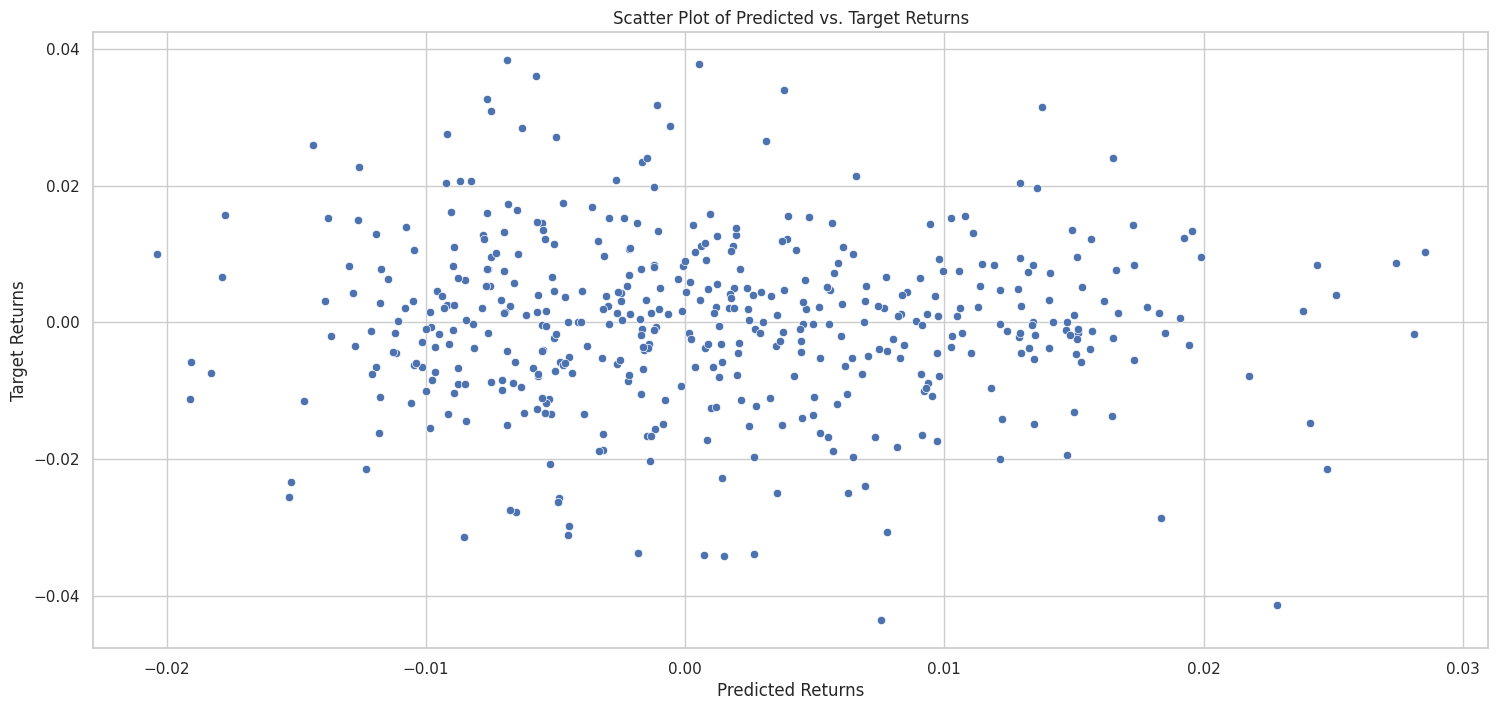

In [ ]:
sns.scatterplot(x = predicted_values[:,0], y = target_values[:,0])
plt.xlabel("Predicted Returns")
plt.ylabel("Target Returns")
plt.title("Scatter Plot of Predicted vs. Target Returns")
plt.show()

Text(0.5, 1.0, 'Cumulative Returns over Time')

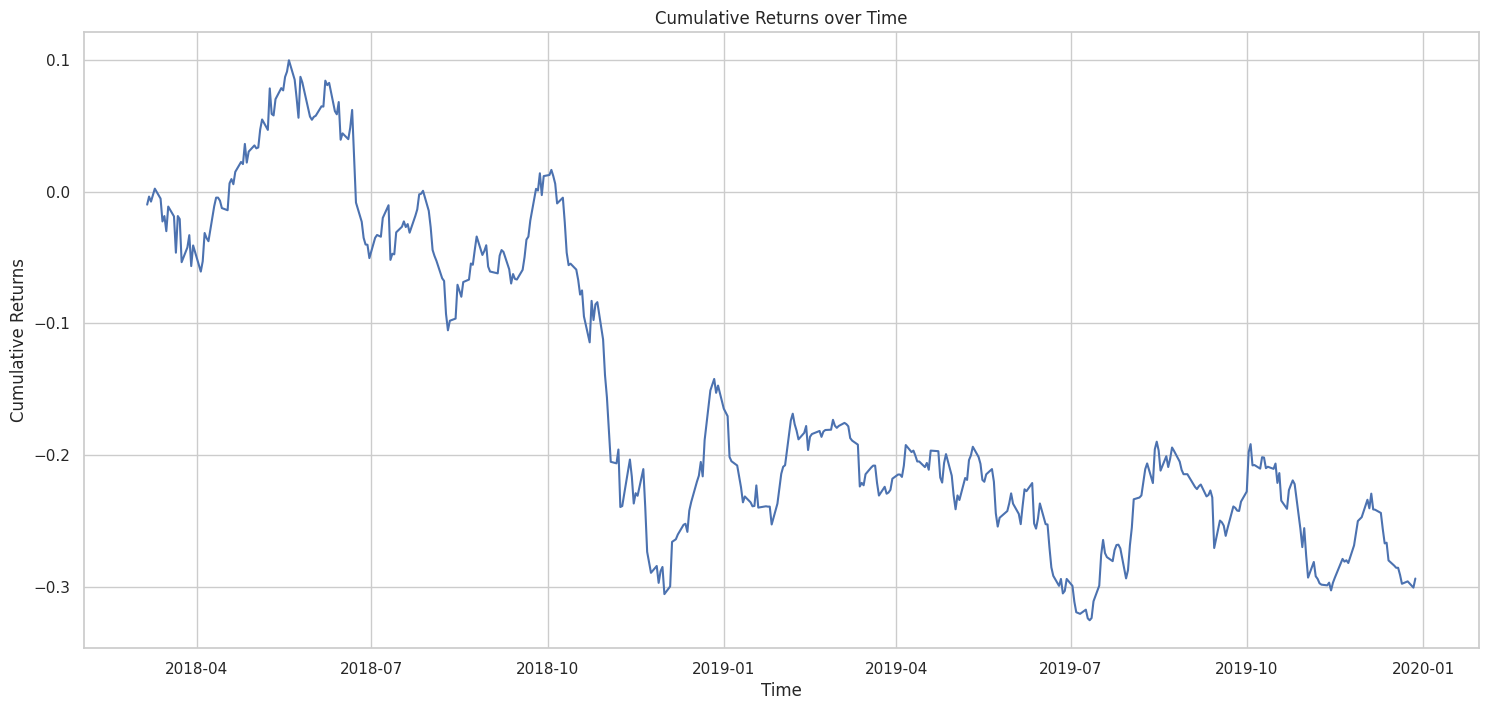

In [ ]:
Returns = pd.Series(np.cumsum(np.sign(predicted_values[:,0]) * target_values[:,0]))
sns.lineplot(x = Dataset.DateTime, y = Returns)
plt.xlabel("Time")
plt.ylabel("Cumulative Returns")
plt.title("Cumulative Returns over Time")

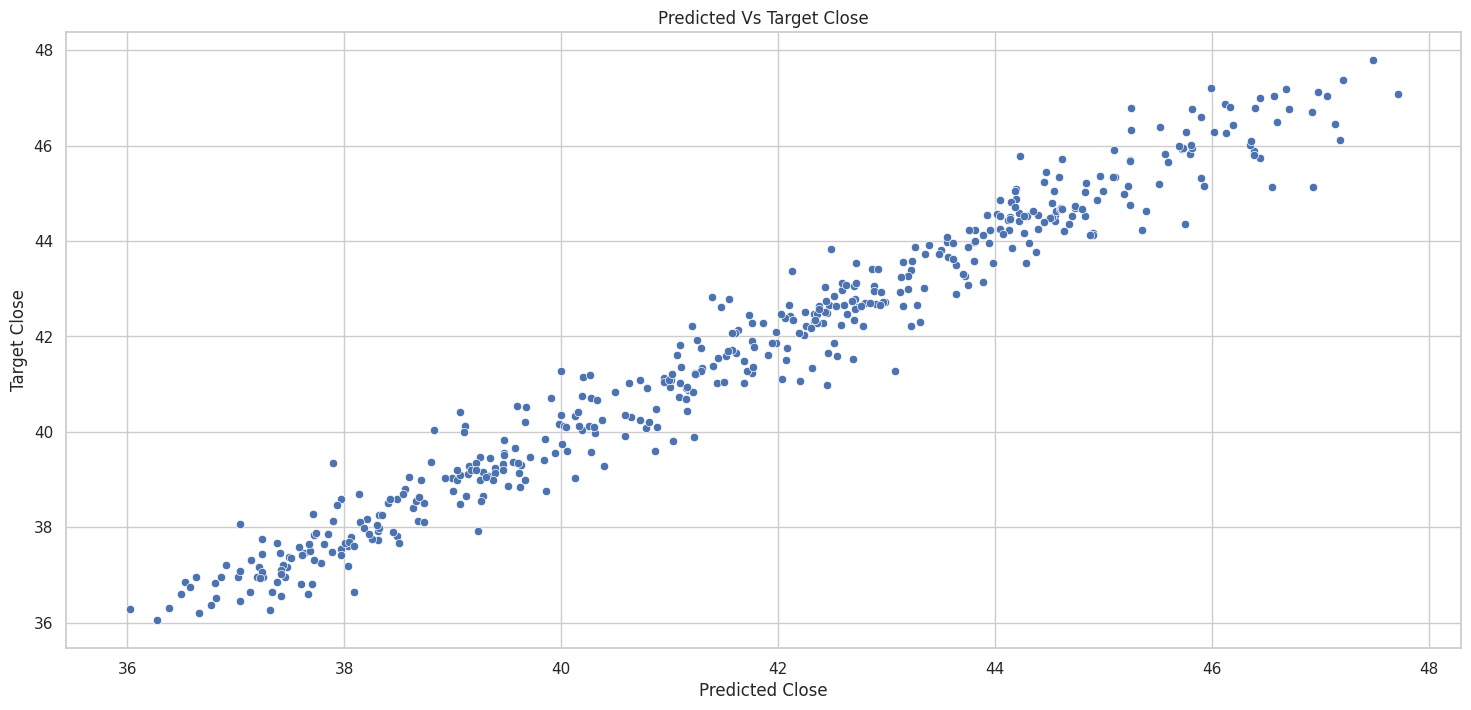

In [ ]:
sns.scatterplot(x = predicted_values[:,1], y = target_values[:,1])
plt.xlabel("Predicted Close")
plt.ylabel("Target Close")
plt.title("Predicted Vs Target Close")
plt.show()

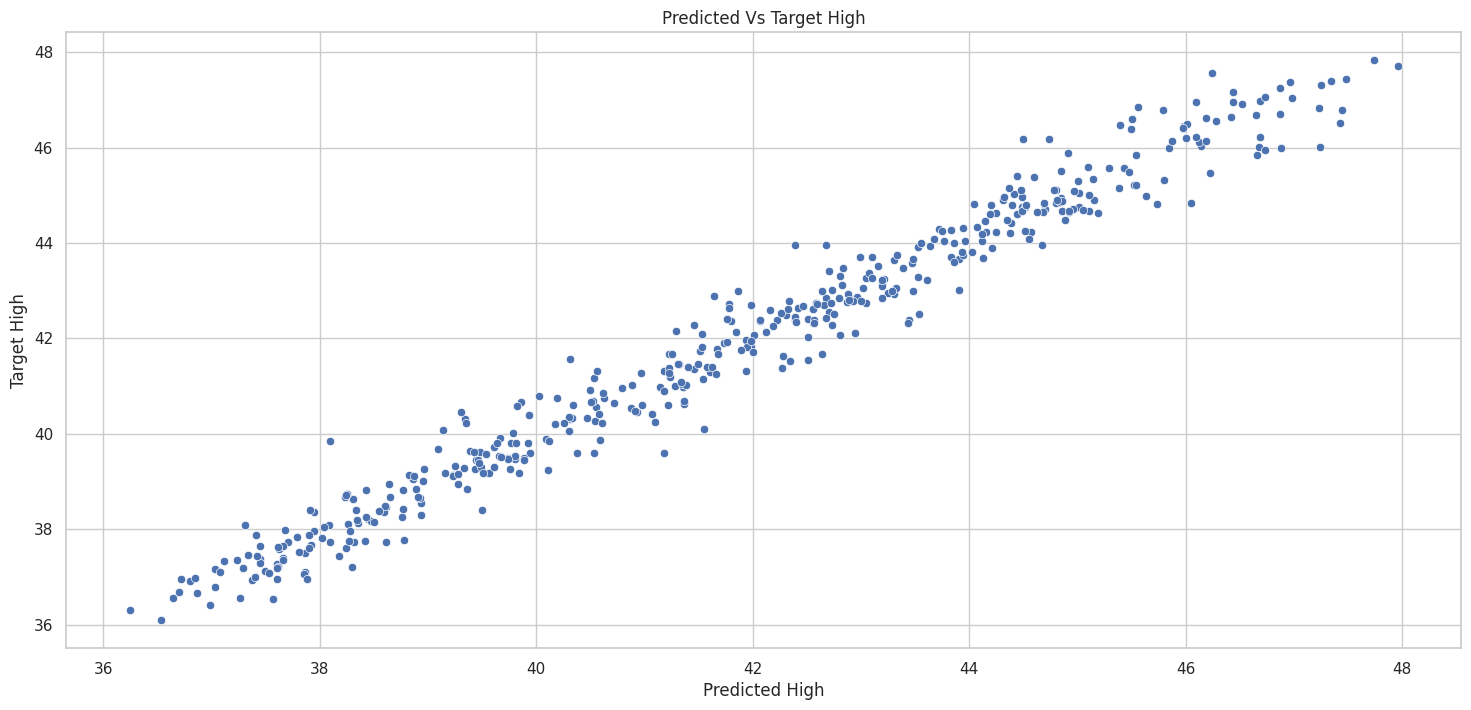

In [ ]:
sns.scatterplot(x = predicted_values[:,2], y = target_values[:,2])
plt.xlabel("Predicted High")
plt.ylabel("Target High")
plt.title("Predicted Vs Target High")
plt.show()

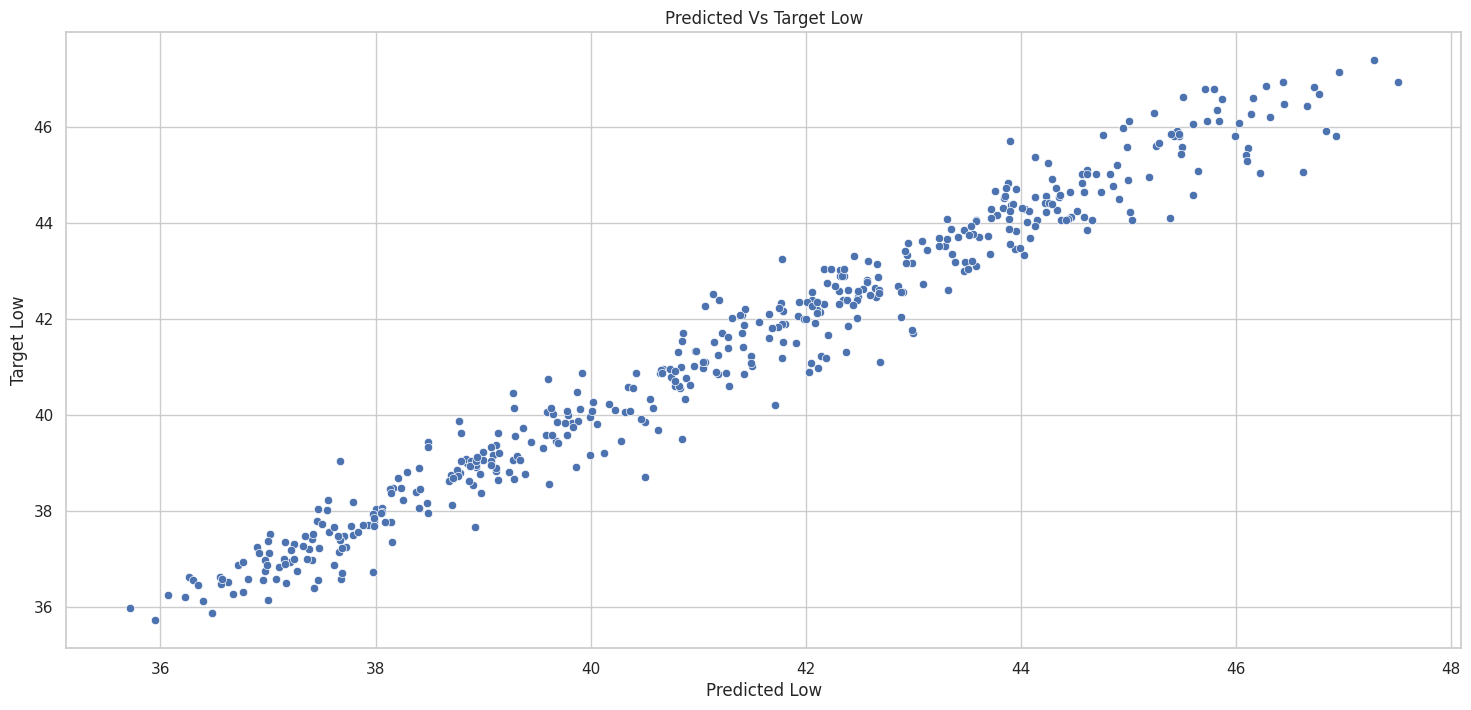

In [ ]:
sns.scatterplot(x = predicted_values[:,3], y = target_values[:,3])
plt.xlabel("Predicted Low")
plt.ylabel("Target Low")
plt.title("Predicted Vs Target Low")
plt.show()

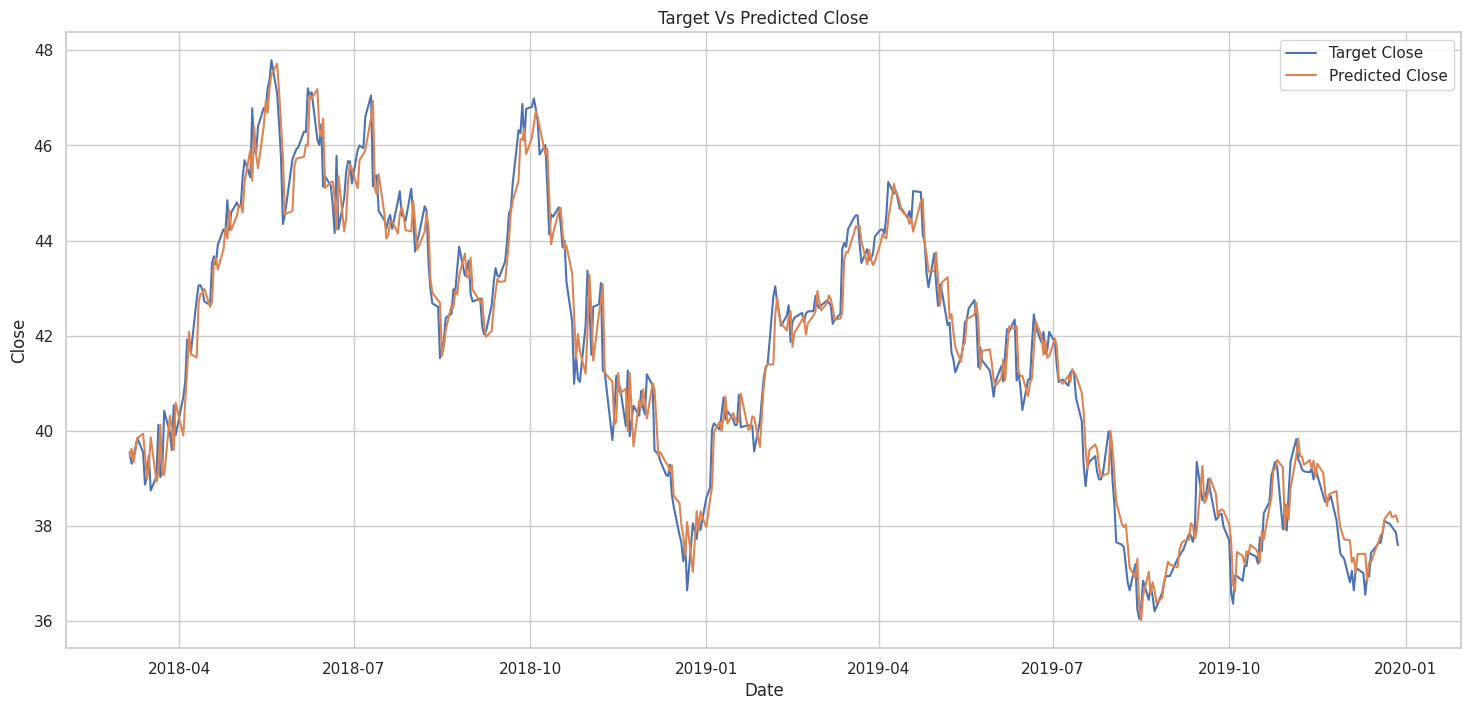

In [ ]:
sns.lineplot(x = Dataset.DateTime, y = target_values[:,1], label = "Target Close")
sns.lineplot(x = Dataset.DateTime, y = predicted_values[:,1], label = "Predicted Close")

plt.xlabel('Date')
plt.ylabel('Close')
plt.title('Target Vs Predicted Close')

plt.legend()  # Add legend based on labels
plt.show()

In [ ]:
print(calculate_metrics(predicted_values[:,1] , target_values[:,1]))
print(calculate_metrics(np.roll(target_values[:,1],1), target_values[:,1]))

(0.28780895, 0.5364783, 0.4078474, 0.9638770252892274, 0.9806969203054905)
(0.27679777, 0.5261157, 0.38775596, 0.9678136331709032, 0.932573713362217)


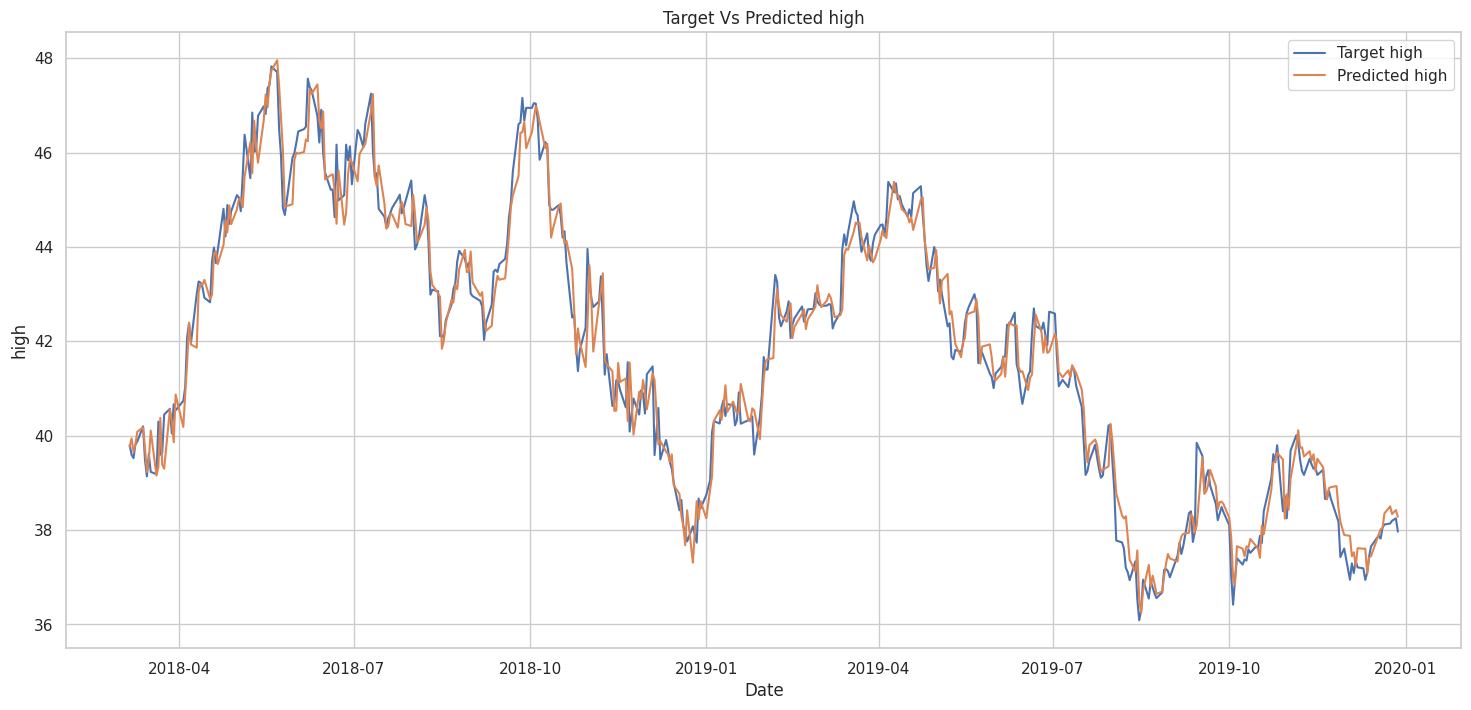

In [ ]:
sns.lineplot(x = Dataset.DateTime, y = target_values[:,2], label = "Target high")
sns.lineplot(x = Dataset.DateTime, y = predicted_values[:,2], label = "Predicted high")

plt.xlabel('Date')
plt.ylabel('high')
plt.title('Target Vs Predicted high')

plt.legend()  # Add legend based on labels
plt.show()

In [ ]:
print(calculate_metrics(predicted_values[:,2] , target_values[:,2]))
print(calculate_metrics(np.roll(target_values[:,2],1), target_values[:,2]))

(0.2415176, 0.4914444, 0.36916143, 0.969845680746247, 0.8816263638436794)
(0.2676536, 0.5173525, 0.3846096, 0.9689221661731069, 0.9184007532894611)


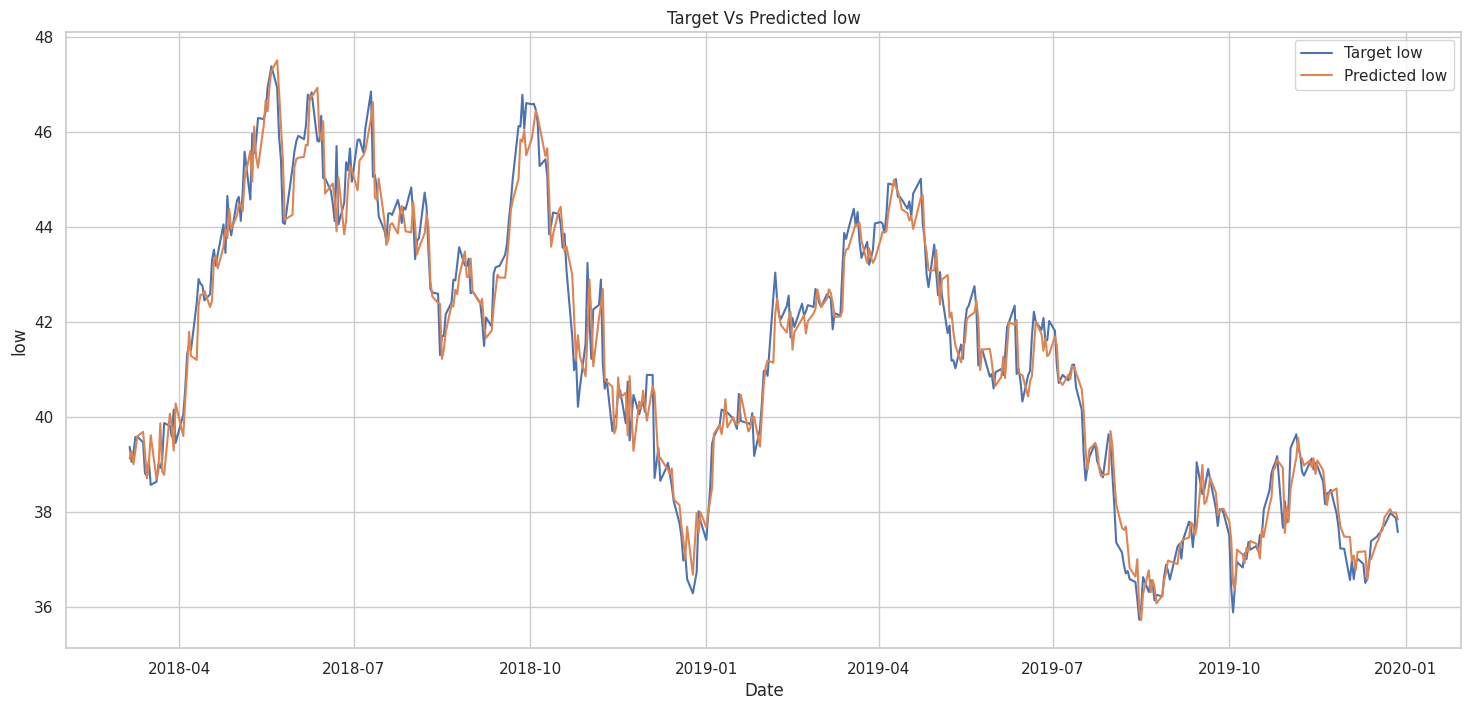

In [ ]:
sns.lineplot(x = Dataset.DateTime, y = target_values[:,3], label = "Target low")
sns.lineplot(x = Dataset.DateTime, y = predicted_values[:,3], label = "Predicted low")

plt.xlabel('Date')
plt.ylabel('low')
plt.title('Target Vs Predicted low')

plt.legend()  # Add legend based on labels
plt.show()

In [ ]:
print(calculate_metrics(predicted_values[:,3] , target_values[:,3]))
print(calculate_metrics(np.roll(target_values[:,3],1), target_values[:,3]))

(0.27716637, 0.5264659, 0.39933178, 0.9652626796930769, 0.9620390832424164)
(0.29400748, 0.5422246, 0.40413457, 0.9655902883462206, 0.9759398177266121)
